# Alternating Least Squares (ALS) Matrix Factorization

Implementation of ALS for collaborative filtering on MovieLens dataset.

## 1. Imports and Data Loading

The split is temporal 75/12.5/12.5, so the model is trained on past interactions and evaluated on future ones.

In [17]:
!git clone https://$GITHUB_TOKEN@github.com/Its-OP/ucu-rs-2026.git

Cloning into 'ucu-rs-2026'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 241 (delta 35), reused 48 (delta 23), pack-reused 168 (from 1)
Receiving objects: 100% (241/241), 78.76 MiB | 39.87 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [18]:
%cd ucu-rs-2026

/content/ucu-rs-2026_old/ucu-rs-2026


We fix random seeds so initialization and shuffling behave consistently across runs, and we reduce noisy warnings/logs to keep the training output readable.

In [19]:
from __future__ import annotations

import os
import sys
import random
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
from scipy import sparse

import matplotlib.pyplot as plt

sys.path.append(str(Path(".").resolve()))

from src.models.base import RecommenderModel, Rating
from src.eval.eval import evaluate
from data.dataframes import movies_enriched, users, train, test

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("src.eval.eval").setLevel(logging.ERROR)

In [20]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

## 2. ALS Model Implementation

We represent each user and item with latent vectors and fit them so their dot product predicts ratings. ALS minimizes the regularized squared error on observed ratings:

&&
\min_{X,Y}\sum_{(u,i)\in\Omega}(r_{ui}-x_u^\top y_i)^2 + \lambda(\lVert X\rVert^2+\lVert Y\rVert^2)
&&

Here:

* $r_{ui}$ is the observed rating
* $x_u$ is the user latent vector
* $y_i$ is the item latent vector
* $\Omega$ is the set of observed user-item pairs
* $\lambda$ is regularization

Instead of optimizing everything at once, we alternate:

* Fix $Y$, solve each $x_u$ in closed form
* Fix $X$, solve each $y_i$ in closed form

For a user $u$ with rated items $\Omega_u$ `_als_step_explicit` with `np.linalg.solve` impements:
$$
x_u \leftarrow (Y_{\Omega_u}^\top Y_{\Omega_u} + \lambda I)^{-1}Y_{\Omega_u}^\top r_u
$$


The implementation subtracts the global mean rating and learns factors around that baseline. Then it tracks training RMSE over observed ratings per iteration.  


For a user $u$, predicted score for item $i$:

$$
\hat{r}_{ui} = \mu + x_u^\top y_i
$$

Seen items are masked out, then we take top-k.

In [21]:
class ALSRecommender(RecommenderModel):
    """Alternating Least Squares matrix factorization for explicit feedback.

    Minimizes: Σ_{observed} (r_ui - x_u · y_i)² + λ(||X||² + ||Y||²)

    Parameters
    ----------
    n_factors : int
        Dimensionality of latent factors.
    n_iterations : int
        Number of ALS iterations.
    regularization : float
        L2 regularization strength.
    random_state : int
        Seed for reproducibility.
    """

    def __init__(
        self,
        n_factors: int = 50,
        n_iterations: int = 15,
        regularization: float = 0.1,
        random_state: int = 42,
    ):
        self.n_factors = n_factors
        self.n_iterations = n_iterations
        self.regularization = regularization
        self.random_state = random_state

        self.global_mean: float = 0.0
        self.user_factors: np.ndarray | None = None
        self.item_factors: np.ndarray | None = None
        self.user_to_idx: Dict[int, int] = {}
        self.item_to_idx: Dict[int, int] = {}
        self.idx_to_item: Dict[int, int] = {}

        self.loss_history_: List[float] = []

    def _build_interaction_matrix(self, ratings: pd.DataFrame) -> sparse.csr_matrix:
        users_list = ratings["UserID"].unique()
        items_list = ratings["MovieID"].unique()

        self.user_to_idx = {u: i for i, u in enumerate(users_list)}
        self.item_to_idx = {m: i for i, m in enumerate(items_list)}
        self.idx_to_item = {i: m for m, i in self.item_to_idx.items()}

        row = ratings["UserID"].map(self.user_to_idx).values
        col = ratings["MovieID"].map(self.item_to_idx).values
        data = ratings["Rating"].values

        return sparse.csr_matrix(
            (data, (row, col)),
            shape=(len(users_list), len(items_list)),
            dtype=np.float32
        )

    def fit(self, ratings: pd.DataFrame) -> "ALSRecommender":
        np.random.seed(self.random_state)

        R = self._build_interaction_matrix(ratings)
        n_users, n_items = R.shape

        self.global_mean = ratings["Rating"].mean() # center ratings by global mean
        R_centered = R.copy()
        R_centered.data = R_centered.data - self.global_mean

        self.user_factors = np.random.normal(0, 0.1, (n_users, self.n_factors)).astype(np.float32)
        self.item_factors = np.random.normal(0, 0.1, (n_items, self.n_factors)).astype(np.float32)

        reg_I = self.regularization * np.eye(self.n_factors, dtype=np.float32)

        # alternating
        for iteration in range(self.n_iterations):
            self._als_step_explicit(R_centered, self.item_factors, self.user_factors, reg_I) # fix items, solve for users
            self._als_step_explicit(R_centered.T.tocsr(), self.user_factors, self.item_factors, reg_I) # fix users, solve for items

            pred = self.user_factors @ self.item_factors.T
            mask = R.toarray() > 0
            diff = (R.toarray() - self.global_mean - pred) * mask
            rmse = np.sqrt(np.sum(diff ** 2) / np.sum(mask))
            self.loss_history_.append(rmse)

            if (iteration + 1) % 5 == 0:
                print(f"  ALS iteration {iteration + 1}/{self.n_iterations}, RMSE: {rmse:.4f}")

        return self

    def _als_step_explicit(
        self,
        R: sparse.csr_matrix,
        fixed: np.ndarray,
        solve_for: np.ndarray,
        reg_I: np.ndarray,
    ) -> None:
        for u in range(solve_for.shape[0]):
            start, end = R.indptr[u], R.indptr[u + 1]
            indices = R.indices[start:end]

            if len(indices) == 0:
                continue

            r_u = R.data[start:end] # centered ratings
            Y_u = fixed[indices] # item factors for rated items

            # (Y^T Y + λI)^{-1} Y^T r
            A = Y_u.T @ Y_u + reg_I
            b = Y_u.T @ r_u

            solve_for[u] = np.linalg.solve(A, b)

    def predict(
        self,
        users: pd.DataFrame,
        ratings: pd.DataFrame,
        movies: pd.DataFrame,
        k: int = 10,
    ) -> Dict[int, List[Rating]]:
        ratings_by_user = {uid: set(grp["MovieID"].values) for uid, grp in ratings.groupby("UserID")}

        preds: Dict[int, List[Rating]] = {}

        for uid in users["UserID"].values:
            uid = int(uid)
            seen = ratings_by_user.get(uid, set())

            if uid not in self.user_to_idx:
                preds[uid] = []
                continue

            u_idx = self.user_to_idx[uid]

            # Predicted rating = global_mean + x_u · y_i
            scores = self.global_mean + self.user_factors[u_idx] @ self.item_factors.T

            # Mask seen items
            for mid in seen:
                if mid in self.item_to_idx:
                    scores[self.item_to_idx[mid]] = -np.inf

            # Top-k
            top_indices = np.argpartition(-scores, min(k, len(scores) - 1))[:k]
            top_indices = top_indices[np.argsort(-scores[top_indices])]

            preds[uid] = [
                Rating(movie_id=int(self.idx_to_item[i]), score=float(scores[i]))
                for i in top_indices
                if scores[i] > -np.inf
            ]

        return preds

## 3. Hyperparameter Configurations

We test ALS with different configurations to understand the impact of:
- Number of latent factors
- Regularization strength
- Confidence scaling (alpha)

In [22]:
ALS_CONFIGS = [
  # anchor around previous best (f=100, reg=0.1, alpha=40)
  {"name":"als_f100_r0.05_a40",  "n_factors":100, "regularization":0.05, "alpha":40},
  {"name":"als_f100_r0.1_a40",   "n_factors":100, "regularization":0.10, "alpha":40},
  {"name":"als_f100_r0.2_a40",   "n_factors":100, "regularization":0.20, "alpha":40},

  {"name":"als_f100_r0.1_a10",   "n_factors":100, "regularization":0.10, "alpha":10},
  {"name":"als_f100_r0.1_a20",   "n_factors":100, "regularization":0.10, "alpha":20},
  {"name":"als_f100_r0.1_a80",   "n_factors":100, "regularization":0.10, "alpha":80},

  # factor sweep at good reg/alpha
  {"name":"als_f50_r0.1_a40",    "n_factors":50,  "regularization":0.10, "alpha":40},
  {"name":"als_f150_r0.1_a40",   "n_factors":150, "regularization":0.10, "alpha":40},
  {"name":"als_f200_r0.1_a40",   "n_factors":200, "regularization":0.10, "alpha":40},

  # couple of combos that we expect to win
  {"name":"als_f150_r0.05_a40",  "n_factors":150, "regularization":0.05, "alpha":40},
  {"name":"als_f150_r0.2_a20",   "n_factors":150, "regularization":0.20, "alpha":20},
]

K_VALUES = [10]
THRESHOLD = 4.0

## 4. Training and Evaluation

In [23]:
results = []
models = {}

for config in ALS_CONFIGS:
    name = config["name"]
    print(f"\nTraining: {name}")
    print(f"{'-'*30}")

    model = ALSRecommender(
        n_factors=config["n_factors"],
        n_iterations=15,
        regularization=config["regularization"],
    )
    model.fit(train)
    models[name] = model

    for k in K_VALUES:
        metrics = evaluate(
            model=model,
            train_ratings=train,
            test_ratings=test,
            users=users,
            movies=movies_enriched,
            k=k,
            threshold=THRESHOLD,
        )

        results.append({
            "model": name,
            "k": k,
            "ndcg": metrics.ndcg,
            "precision": metrics.precision,
            "recall": metrics.recall,
        })


Training: als_f100_r0.05_a40
------------------------------
  ALS iteration 5/15, RMSE: 0.3607
  ALS iteration 10/15, RMSE: 0.3170
  ALS iteration 15/15, RMSE: 0.2979

Training: als_f100_r0.1_a40
------------------------------
  ALS iteration 5/15, RMSE: 0.3557
  ALS iteration 10/15, RMSE: 0.3127
  ALS iteration 15/15, RMSE: 0.2941

Training: als_f100_r0.2_a40
------------------------------
  ALS iteration 5/15, RMSE: 0.3515
  ALS iteration 10/15, RMSE: 0.3093
  ALS iteration 15/15, RMSE: 0.2914

Training: als_f100_r0.1_a10
------------------------------
  ALS iteration 5/15, RMSE: 0.3557
  ALS iteration 10/15, RMSE: 0.3127
  ALS iteration 15/15, RMSE: 0.2941

Training: als_f100_r0.1_a20
------------------------------
  ALS iteration 5/15, RMSE: 0.3557
  ALS iteration 10/15, RMSE: 0.3127
  ALS iteration 15/15, RMSE: 0.2941

Training: als_f100_r0.1_a80
------------------------------
  ALS iteration 5/15, RMSE: 0.3557
  ALS iteration 10/15, RMSE: 0.3127
  ALS iteration 15/15, RMSE: 0.29

## 5. Convergence Analysis

ALS uses closed-form solutions alternating between user and item factors.
We track RMSE on observed ratings per iteration.

Observations:
- ALS converges monotonically (guaranteed by closed-form solution)
- Higher regularization → higher final loss but prevents overfitting
- More factors → lower training loss but increased computation

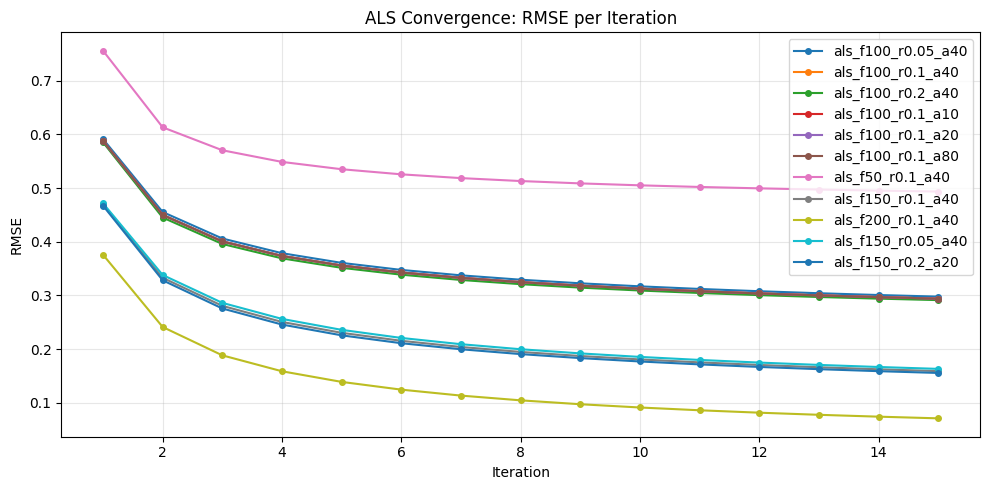

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

for name, model in models.items():
    ax.plot(range(1, len(model.loss_history_) + 1), model.loss_history_, label=name, marker='o', markersize=4)

ax.set_xlabel("Iteration")
ax.set_ylabel("RMSE")
ax.set_title("ALS Convergence: RMSE per Iteration")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Results Summary

In [25]:
results_df = pd.DataFrame(results)
print("\nAll Results:")
print(results_df.to_string(index=False))

print("\n\nNDCG@K by Model:")
ndcg_pivot = results_df.pivot(index="model", columns="k", values="ndcg")
print(ndcg_pivot.round(4))

print("\n\nPrecision@K by Model:")
prec_pivot = results_df.pivot(index="model", columns="k", values="precision")
print(prec_pivot.round(4))

print("\n\nRecall@K by Model:")
recall_pivot = results_df.pivot(index="model", columns="k", values="recall")
print(recall_pivot.round(4))


All Results:
             model  k     ndcg  precision   recall
als_f100_r0.05_a40 10 0.009795   0.008586 0.001137
 als_f100_r0.1_a40 10 0.012628   0.010859 0.001573
 als_f100_r0.2_a40 10 0.021663   0.019285 0.003182
 als_f100_r0.1_a10 10 0.012628   0.010859 0.001573
 als_f100_r0.1_a20 10 0.012628   0.010859 0.001573
 als_f100_r0.1_a80 10 0.012628   0.010859 0.001573
  als_f50_r0.1_a40 10 0.008936   0.006229 0.000986
 als_f150_r0.1_a40 10 0.024157   0.020660 0.004318
 als_f200_r0.1_a40 10 0.034804   0.030165 0.005366
als_f150_r0.05_a40 10 0.018184   0.015591 0.002984
 als_f150_r0.2_a20 10 0.030870   0.026980 0.005648


NDCG@K by Model:
k                       10
model                     
als_f100_r0.05_a40  0.0098
als_f100_r0.1_a10   0.0126
als_f100_r0.1_a20   0.0126
als_f100_r0.1_a40   0.0126
als_f100_r0.1_a80   0.0126
als_f100_r0.2_a40   0.0217
als_f150_r0.05_a40  0.0182
als_f150_r0.1_a40   0.0242
als_f150_r0.2_a20   0.0309
als_f200_r0.1_a40   0.0348
als_f50_r0.1_a40    0.0089


Pr

## 7. Best Model Selection

In [26]:
# at K=10
k10_results = results_df[results_df["k"] == 10].sort_values("ndcg", ascending=False)
print("\nModels ranked by NDCG@10:")
print(k10_results.to_string(index=False))

best_model_name = k10_results.iloc[0]["model"]
print(f"\nBest model: {best_model_name}")


Models ranked by NDCG@10:
             model  k     ndcg  precision   recall
 als_f200_r0.1_a40 10 0.034804   0.030165 0.005366
 als_f150_r0.2_a20 10 0.030870   0.026980 0.005648
 als_f150_r0.1_a40 10 0.024157   0.020660 0.004318
 als_f100_r0.2_a40 10 0.021663   0.019285 0.003182
als_f150_r0.05_a40 10 0.018184   0.015591 0.002984
 als_f100_r0.1_a20 10 0.012628   0.010859 0.001573
 als_f100_r0.1_a40 10 0.012628   0.010859 0.001573
 als_f100_r0.1_a10 10 0.012628   0.010859 0.001573
 als_f100_r0.1_a80 10 0.012628   0.010859 0.001573
als_f100_r0.05_a40 10 0.009795   0.008586 0.001137
  als_f50_r0.1_a40 10 0.008936   0.006229 0.000986

Best model: als_f200_r0.1_a40


## 8. Example Recommendations

In [27]:
example_user = int(train["UserID"].value_counts().index[0])
print(f"\nExample recommendations for user {example_user}:")

best_model = models[best_model_name]
recs = best_model.predict(
    users=users[users["UserID"] == example_user],
    ratings=train,
    movies=movies_enriched,
    k=10
)[example_user]

rec_ids = [r.movie_id for r in recs]
rec_scores = {r.movie_id: r.score for r in recs}

show_df = movies_enriched[movies_enriched["movie_id"].isin(rec_ids)][["movie_id", "title", "year", "genres"]].copy()
show_df["rank"] = show_df["movie_id"].map({mid: i+1 for i, mid in enumerate(rec_ids)})
show_df["score"] = show_df["movie_id"].map(rec_scores).round(3)
show_df = show_df.sort_values("rank")

print(show_df.to_string(index=False))


Example recommendations for user 1680:
 movie_id                   title  year                              genres  rank  score
     1212          Third Man, The  1949                    Mystery|Thriller     1  7.543
      232     Eat Drink Man Woman  1994                        Comedy|Drama     2  7.452
     1103   Rebel Without a Cause  1955                               Drama     3  6.658
     2058         Negotiator, The  1998                     Action|Thriller     4  6.503
     3022            General, The  1927                              Comedy     5  6.379
     2102        Steamboat Willie  1940 Animation|Children's|Comedy|Musical     6  5.950
     1395                 Tin Men  1987                        Comedy|Drama     7  5.943
     2454                Fly, The  1958                       Horror|Sci-Fi     8  5.940
      515 Remains of the Day, The  1993                               Drama     9  5.938
     2273               Rush Hour  1998                     Action|Thr

## 9. User History for Context

In [28]:
user_history = train[train["UserID"] == example_user].merge(
    movies_enriched[["movie_id", "title", "genres"]],
    left_on="MovieID",
    right_on="movie_id"
).sort_values("Rating", ascending=False)

print(f"\nUser {example_user}'s top-rated movies in training set:")
print(user_history[["title", "genres", "Rating"]].head(10).to_string(index=False))


User 1680's top-rated movies in training set:
                title                     genres  Rating
            Manhattan       Comedy|Drama|Romance       5
      Sophie's Choice                      Drama       5
     Mulholland Falls   Crime|Film-Noir|Thriller       5
     Crying Game, The          Drama|Romance|War       5
       Basic Instinct           Mystery|Thriller       5
            Chinatown Film-Noir|Mystery|Thriller       5
Bringing Out the Dead               Drama|Horror       5
                Trust               Comedy|Drama       5
     Harold and Maude                     Comedy       5
           Sting, The               Comedy|Crime       5
